<a href="https://colab.research.google.com/github/tnc-br/ddf-isoscapes/blob/raster_cache/data_ingestion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Ingestion

In [1]:
#@title Imports and modules.
%pip install opencv-python
%pip install matplotlib
%pip install pandas

from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
import matplotlib.animation as animation
from matplotlib import rc
from typing import List
from numpy.random import MT19937, RandomState, SeedSequence
import pandas as pd
from tqdm import tqdm
from io import StringIO
import xgboost as xgb
import os
import math
import glob

rc('animation', html='jshtml')

import sys
!if [ ! -d "/content/ddf_common_stub" ] ; then git clone -b test https://github.com/tnc-br/ddf_common_stub.git; fi
sys.path.append("/content/ddf_common_stub/")
import ddfimport
# ddfimport.ddf_source_control_pane()
ddfimport.ddf_import_common()

import dataset
import raster

Cloning into 'ddf_common_stub'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 18 (delta 7), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (18/18), 7.36 KiB | 1.47 MiB/s, done.
Resolving deltas: 100% (7/7), done.
executing checkout_branch ...
b''
main branch checked out as readonly. You may now use ddf_common imports


## Load dataset

Please select the source of your data to process. Only SAMPLE_CSV_PATH will be used if SAMPLE_SOURCE is set to "GOOGLE DRIVE":

In [2]:
import ipywidgets as widgets

#@markdown ## Data Source

SAMPLE_SOURCE = "GOOGLE DRIVE" #@param ["TIMBERID", "GOOGLE DRIVE"]

#@markdown For TIMERBID SAMPLE_SOURCE only
ORG_NAME = "google" #@param ["google", "USP"]
TEST_ENVIRONMENT = True #@param {type:"boolean"}
#@markdown For GOOGLE DRIVE SAMPLE_SOURCE only
SAMPLE_CSV_PATH = "canonical/2023_07_27_Results_google_relabeled.csv" #@param
SHARED_DRIVE = True #@param {type:"boolean"}

if SAMPLE_SOURCE == "TIMBERID":
  df = dataset.load_reference_samples(org_name=ORG_NAME,
                                      filters=[],
                                      test_environment=TEST_ENVIRONMENT)
elif SAMPLE_SOURCE == "GOOGLE DRIVE":
  raster.mount_gdrive()
  if SHARED_DRIVE:
    df = pd.read_csv(
        os.path.join("/content/gdrive/Shareddrives/TNC Fellowship 🌳/4. Isotope Research & Signals/code/amazon_rainforest_files/amazon_sample_data",
                     SAMPLE_CSV_PATH),
                     encoding="ISO-8859-1",
                     sep=',')
  else:
    df = pd.read_csv(raster.get_sample_db_path(SAMPLE_CSV_PATH),
                     encoding="ISO-8859-1", sep=',')

#@markdown For both sample sources
MANUAL_OVERRIDE_COLUMNS = False #@param {type: "boolean"}

# Internal. The values to select by default
default_values = {
    'Code': True,
    'lat': True,
    'long': True,
    'VPD': True,
    'RH': True,
    'DEM': True,
    'PA': True,
    'PET': True,
    'Mean Annual Temperature': True,
    'Mean Annual Precipitation': True,
    'Iso_Oxi_Stack_mean_TERZER': True,
    'predkrig_br_lat_ISORG': True,
    'brisoscape_mean_ISORIX': True,
    'isoscape_fullmodel_d18O_prec_REGRESSION': True
}
data = df.columns
feature_checkboxes = [widgets.Checkbox(value=False, description=label) for label in data]
for i in range(0, len(feature_checkboxes)):
    if feature_checkboxes[i].description in default_values:
      feature_checkboxes[i].value = True
      default_values.pop(feature_checkboxes[i].description)
if MANUAL_OVERRIDE_COLUMNS:
  output = widgets.VBox(children=feature_checkboxes)
  print("Select the features for your model:")
  display(output)
else:
  if len(default_values) > 0:
    print("Warning: The following columns were not found:",
            list(default_values.keys()))


data = df.columns
default_values = {
    'd18O_cel': True
}
label_checkboxes = [widgets.Checkbox(value=False, description=label) for label in data]
for i in range(0, len(label_checkboxes)):
    if label_checkboxes[i].description in default_values:
      label_checkboxes[i].value = True
      default_values.pop(label_checkboxes[i].description)
if MANUAL_OVERRIDE_COLUMNS:
  output = widgets.VBox(children=label_checkboxes)
  print("Select the labels of your model:")
  display(output)
else:
  if len(default_values) > 0:
    print("Warning: The following columns were not found:",
            list(default_values.keys()))

#@markdown ## Partition Data
#
#@markdown Based on the columns available, you'll select the keys by which we'll split your data into training, validation and test splits. This will make sure that there's a single group of measurements in either of the splits, and not an incomplete unit across many partitions.
#
#@markdown PARTITION_STRATEGY: The columns that will be used to group the dataset to calculate means and variance on LABEL_COLUMNS. Values can be
#@markdown - FIXED
#@markdown - RANDOM

PARTITION_STRATEGY = "FIXED" #@param ["FIXED", "RANDOM"]
GROUPING_COLUMNS = ["Code", "lat", "long"] #@param

#@markdown KEEP_GROUPING: If True, the exported rows will have unique values of the grouping columns selected above. If False, the exported rows will still contain the mean, variance, and other statistics for each group, but the original set of rows will be exported without combining any rows.

KEEP_GROUPING = True #@param {type: "boolean"}

Mounted at /content/gdrive


In [3]:
# @title
selected_data = []
for i in range(0, len(feature_checkboxes)):
    if feature_checkboxes[i].value == True:
        selected_data = selected_data + [feature_checkboxes[i].description]
print("Selected features: ", selected_data)
FEATURE_COLUMNS = selected_data

selected_data = []
for i in range(0, len(label_checkboxes)):
    if label_checkboxes[i].value == True:
        assert(label_checkboxes[i].description not in FEATURE_COLUMNS)
        selected_data = selected_data + [label_checkboxes[i].description]
print("Selected labels: ", selected_data)
LABEL_COLUMNS = selected_data

print("Partitioning strategy: ", PARTITION_STRATEGY)
print("Grouping columns:", GROUPING_COLUMNS)

Selected features:  ['Code', 'lat', 'long', 'VPD', 'RH', 'PET', 'DEM', 'PA', 'Mean Annual Temperature', 'Mean Annual Precipitation', 'Iso_Oxi_Stack_mean_TERZER', 'predkrig_br_lat_ISORG', 'brisoscape_mean_ISORIX', 'isoscape_fullmodel_d18O_prec_REGRESSION']
Selected labels:  ['d18O_cel']
Partitioning strategy:  FIXED
Grouping columns: ['Code', 'lat', 'long']


## Pre-Process and Split Data

In [4]:
# @title Run this cell to pre-process and split data
import partitioned_dataset
import dataset

import importlib
importlib.reload(dataset)
importlib.reload(partitioned_dataset)
import dataset
import partitioned_dataset

from partitioned_dataset import PartitionStrategy

for column in LABEL_COLUMNS:
  df[column] = df[column].astype(float)

sample_data = dataset.preprocess_sample_data(df, FEATURE_COLUMNS, LABEL_COLUMNS, GROUPING_COLUMNS, KEEP_GROUPING)

resulting_dataset = None
if PARTITION_STRATEGY == "FIXED":
  resulting_dataset = partitioned_dataset.partition(sample_data, PartitionStrategy.FIXED)
elif PARTITION_STRATEGY == "RANDOM":
  resulting_dataset = partitioned_dataset.partition(sample_data, PartitionStrategy.RANDOM)
else:
  raise ValueError(f"Unknown partition strategy: {PARTITION_STRATEGY}")

train_data = resulting_dataset.train
validation_data = resulting_dataset.validation
test_data = resulting_dataset.test


## (Optional) Visualize data

Rows in training set: 73
Rows in validation set:  40
Rows in test set: 106


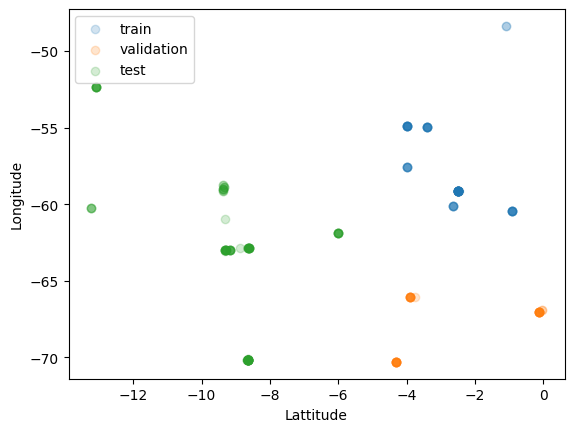

In [ ]:
# @title Run this cell to visualize your partitioned data.
print("Rows in training set:", train_data.shape[0])
print("Rows in validation set: ", validation_data.shape[0])
print("Rows in test set:", test_data.shape[0])

# Optional (plot splits)
import matplotlib
import matplotlib.pyplot as plt

plt.scatter(train_data["lat"], train_data["long"], label="train", alpha=0.2)
plt.scatter(validation_data["lat"], validation_data["long"], label="validation", alpha=0.2)
plt.scatter(test_data["lat"], test_data["long"], label="test", alpha=0.2)
plt.xlabel('Lattitude')
plt.ylabel('Longitude')
plt.legend()
plt.show()

# Add raster features

In [7]:
# @title Run this cell to add raster features
import eeraster
import eeddf
import ee

eeddf.initialize_ddf(test_environment = True)

FEATURE_RASTER_FOLDER = 'ddf_raster_cache'
RASTER_NAMES = ['uc_davis_d18O_cel_ordinary_random_grouped_means', 'uc_davis_d18O_cel_ordinary_random_grouped_vars'] #@param

for raster_name in RASTER_NAMES:
  image = ee.Image(
        'projects/' + eeddf.ee_project_name() + '/assets/reference_rasters/' +
        raster_name)
  task = ee.batch.Export.image.toDrive(
      image=image,
      description=raster_name,
      folder=FEATURE_RASTER_FOLDER,
  )
  task.start()

Per the Earth Engine API, you will need to wait until the tasks created in the Code Editor are completed. Once this is done, you may proceed.

In [8]:
feature_rasters = {}
for raster_name in RASTER_NAMES:
  feature_raster = raster.load_raster(os.path.join(
      "/content/gdrive/MyDrive", FEATURE_RASTER_FOLDER, f"{raster_name}.tif"))
  feature_rasters[raster_name] = feature_raster

for idx, row in train_data.iterrows():
  lat = row["lat"]
  long = row["long"]
  for raster_name in RASTER_NAMES:
    train_data.loc[idx, raster_name] = feature_rasters[raster_name].value_at(long, lat)

for idx, row in validation_data.iterrows():
  lat = row["lat"]
  long = row["long"]
  for raster_name in RASTER_NAMES:
    validation_data.loc[idx, raster_name] = feature_rasters[raster_name].value_at(long, lat)

for idx, row in test_data.iterrows():
  lat = row["lat"]
  long = row["long"]
  for raster_name in RASTER_NAMES:
    test_data.loc[idx, raster_name] = feature_rasters[raster_name].value_at(long, lat)

Driver: GTiff/GeoTIFF
Size is 237 x 236 x 1
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-74.16666666666808, 5.500000000668081)
Pixel Size = (0.16666666666808508, -0.16666666666808505)
Driver: GTiff/GeoTIFF
Size is 237 x 236 x 1
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-74.16666666666808, 5.500000000668081)
Pixel Size = (0.16666666666808508, -0.16666666666808505)


<ipython-input-8-ad548ec9e4d0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[idx, raster_name] = feature_rasters[raster_name].value_at(long, lat)
<ipython-input-8-ad548ec9e4d0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[idx, raster_name] = feature_rasters[raster_name].value_at(long, lat)
<ipython-input-8-ad548ec9e4d0>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

# Export processed dataset

In [9]:
OUTPUT_DATASET_NAME="ee_raster_cache_test" #@param
OUTPUT_DATASET_ROOT = "local_test/" #@param

GROUPING_STR = "grouped" if KEEP_GROUPING else "ungrouped"

SHARED_DRIVE = True #@param {type:"boolean"}
CREATE_PATH_IF_NOT_EXISTS = True #@param {type:"boolean"}

dataset_root = OUTPUT_DATASET_ROOT
if SHARED_DRIVE:
  dataset_root = os.path.join(
      "/content/gdrive/Shareddrives/TNC Fellowship 🌳/4. Isotope Research & Signals/code/amazon_rainforest_files/amazon_sample_data",
      dataset_root
  )
else:
  dataset_root = raster.get_sample_db_path(dataset_root)

if (CREATE_PATH_IF_NOT_EXISTS and
      not os.path.exists(dataset_root)):
  os.mkdir(dataset_root)
  print("Created directory path at:", dataset_root)

OUTPUT_TRAIN_CSV_PATH = f"{dataset_root}{OUTPUT_DATASET_NAME}_train_{PARTITION_STRATEGY.lower()}_{GROUPING_STR}.csv"
OUTPUT_VALIDATION_CSV_PATH = f"{dataset_root}{OUTPUT_DATASET_NAME}_validation_{PARTITION_STRATEGY.lower()}_{GROUPING_STR}.csv"
OUTPUT_TEST_CSV_PATH = f"{dataset_root}{OUTPUT_DATASET_NAME}_test_{PARTITION_STRATEGY.lower()}_{GROUPING_STR}.csv"

print("OUTPUT_TRAIN_CSV_PATH: ", OUTPUT_TRAIN_CSV_PATH)
print("OUTPUT_VALIDATION_CSV_PATH: ", OUTPUT_VALIDATION_CSV_PATH)
print("OUTPUT_TEST_CSV_PATH: ", OUTPUT_TEST_CSV_PATH)

train_data.to_csv(OUTPUT_TRAIN_CSV_PATH)
validation_data.to_csv(OUTPUT_VALIDATION_CSV_PATH)
test_data.to_csv(OUTPUT_TEST_CSV_PATH)

OUTPUT_TRAIN_CSV_PATH:  /content/gdrive/Shareddrives/TNC Fellowship 🌳/4. Isotope Research & Signals/code/amazon_rainforest_files/amazon_sample_data/local_test/ee_raster_cache_test_train_fixed_grouped.csv
OUTPUT_VALIDATION_CSV_PATH:  /content/gdrive/Shareddrives/TNC Fellowship 🌳/4. Isotope Research & Signals/code/amazon_rainforest_files/amazon_sample_data/local_test/ee_raster_cache_test_validation_fixed_grouped.csv
OUTPUT_TEST_CSV_PATH:  /content/gdrive/Shareddrives/TNC Fellowship 🌳/4. Isotope Research & Signals/code/amazon_rainforest_files/amazon_sample_data/local_test/ee_raster_cache_test_test_fixed_grouped.csv
